# The atmosphere and its layers¶

The World Meteorological Organization (WMO) defines the atmosphere as:

``A hypothetical vertical distribution of atmospheric temperature, pressure and density which by international agreement and for historical reasons, is roughly representative of year-round, midlatitude conditions.``

In fact, the atmosphere is the mean that makes the link between the ground and space and it is crucial when studying perturbations since drag affects LEO satellites.

Therefore, it was necessary to develop some mathematical model that could predict all the different conditions stated in WMO atmosphere definition for given altitudes.

Along history different models have been developed:

    ISA: up to 11 km.

    ISA-ICAO: up to 80 km.

    COESA 1962: up to 700 km.

    COESA 1976: up to 1000 km.

    Jacchia-Roberts

Since some of them are implemented in poliastro, let us compare the differences among them:

In [1]:
from astropy import units as u

from matplotlib import pyplot as plt
import numpy as np

from poliastro.earth.atmosphere import COESA62, COESA76

import matplotlib.pyplot as plt


In [2]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['figure.dpi'] = 300

## Comparing coesa62 and coesa76¶

Also known as U.S. Standard Atmosphere, the atmospheric model coesa76 is just an update of its little brother coesa62. The difference is that geopotential heights diverge for higher altitudes.

Let us plot the Temperature as increasing altitude for both atmospheric models:

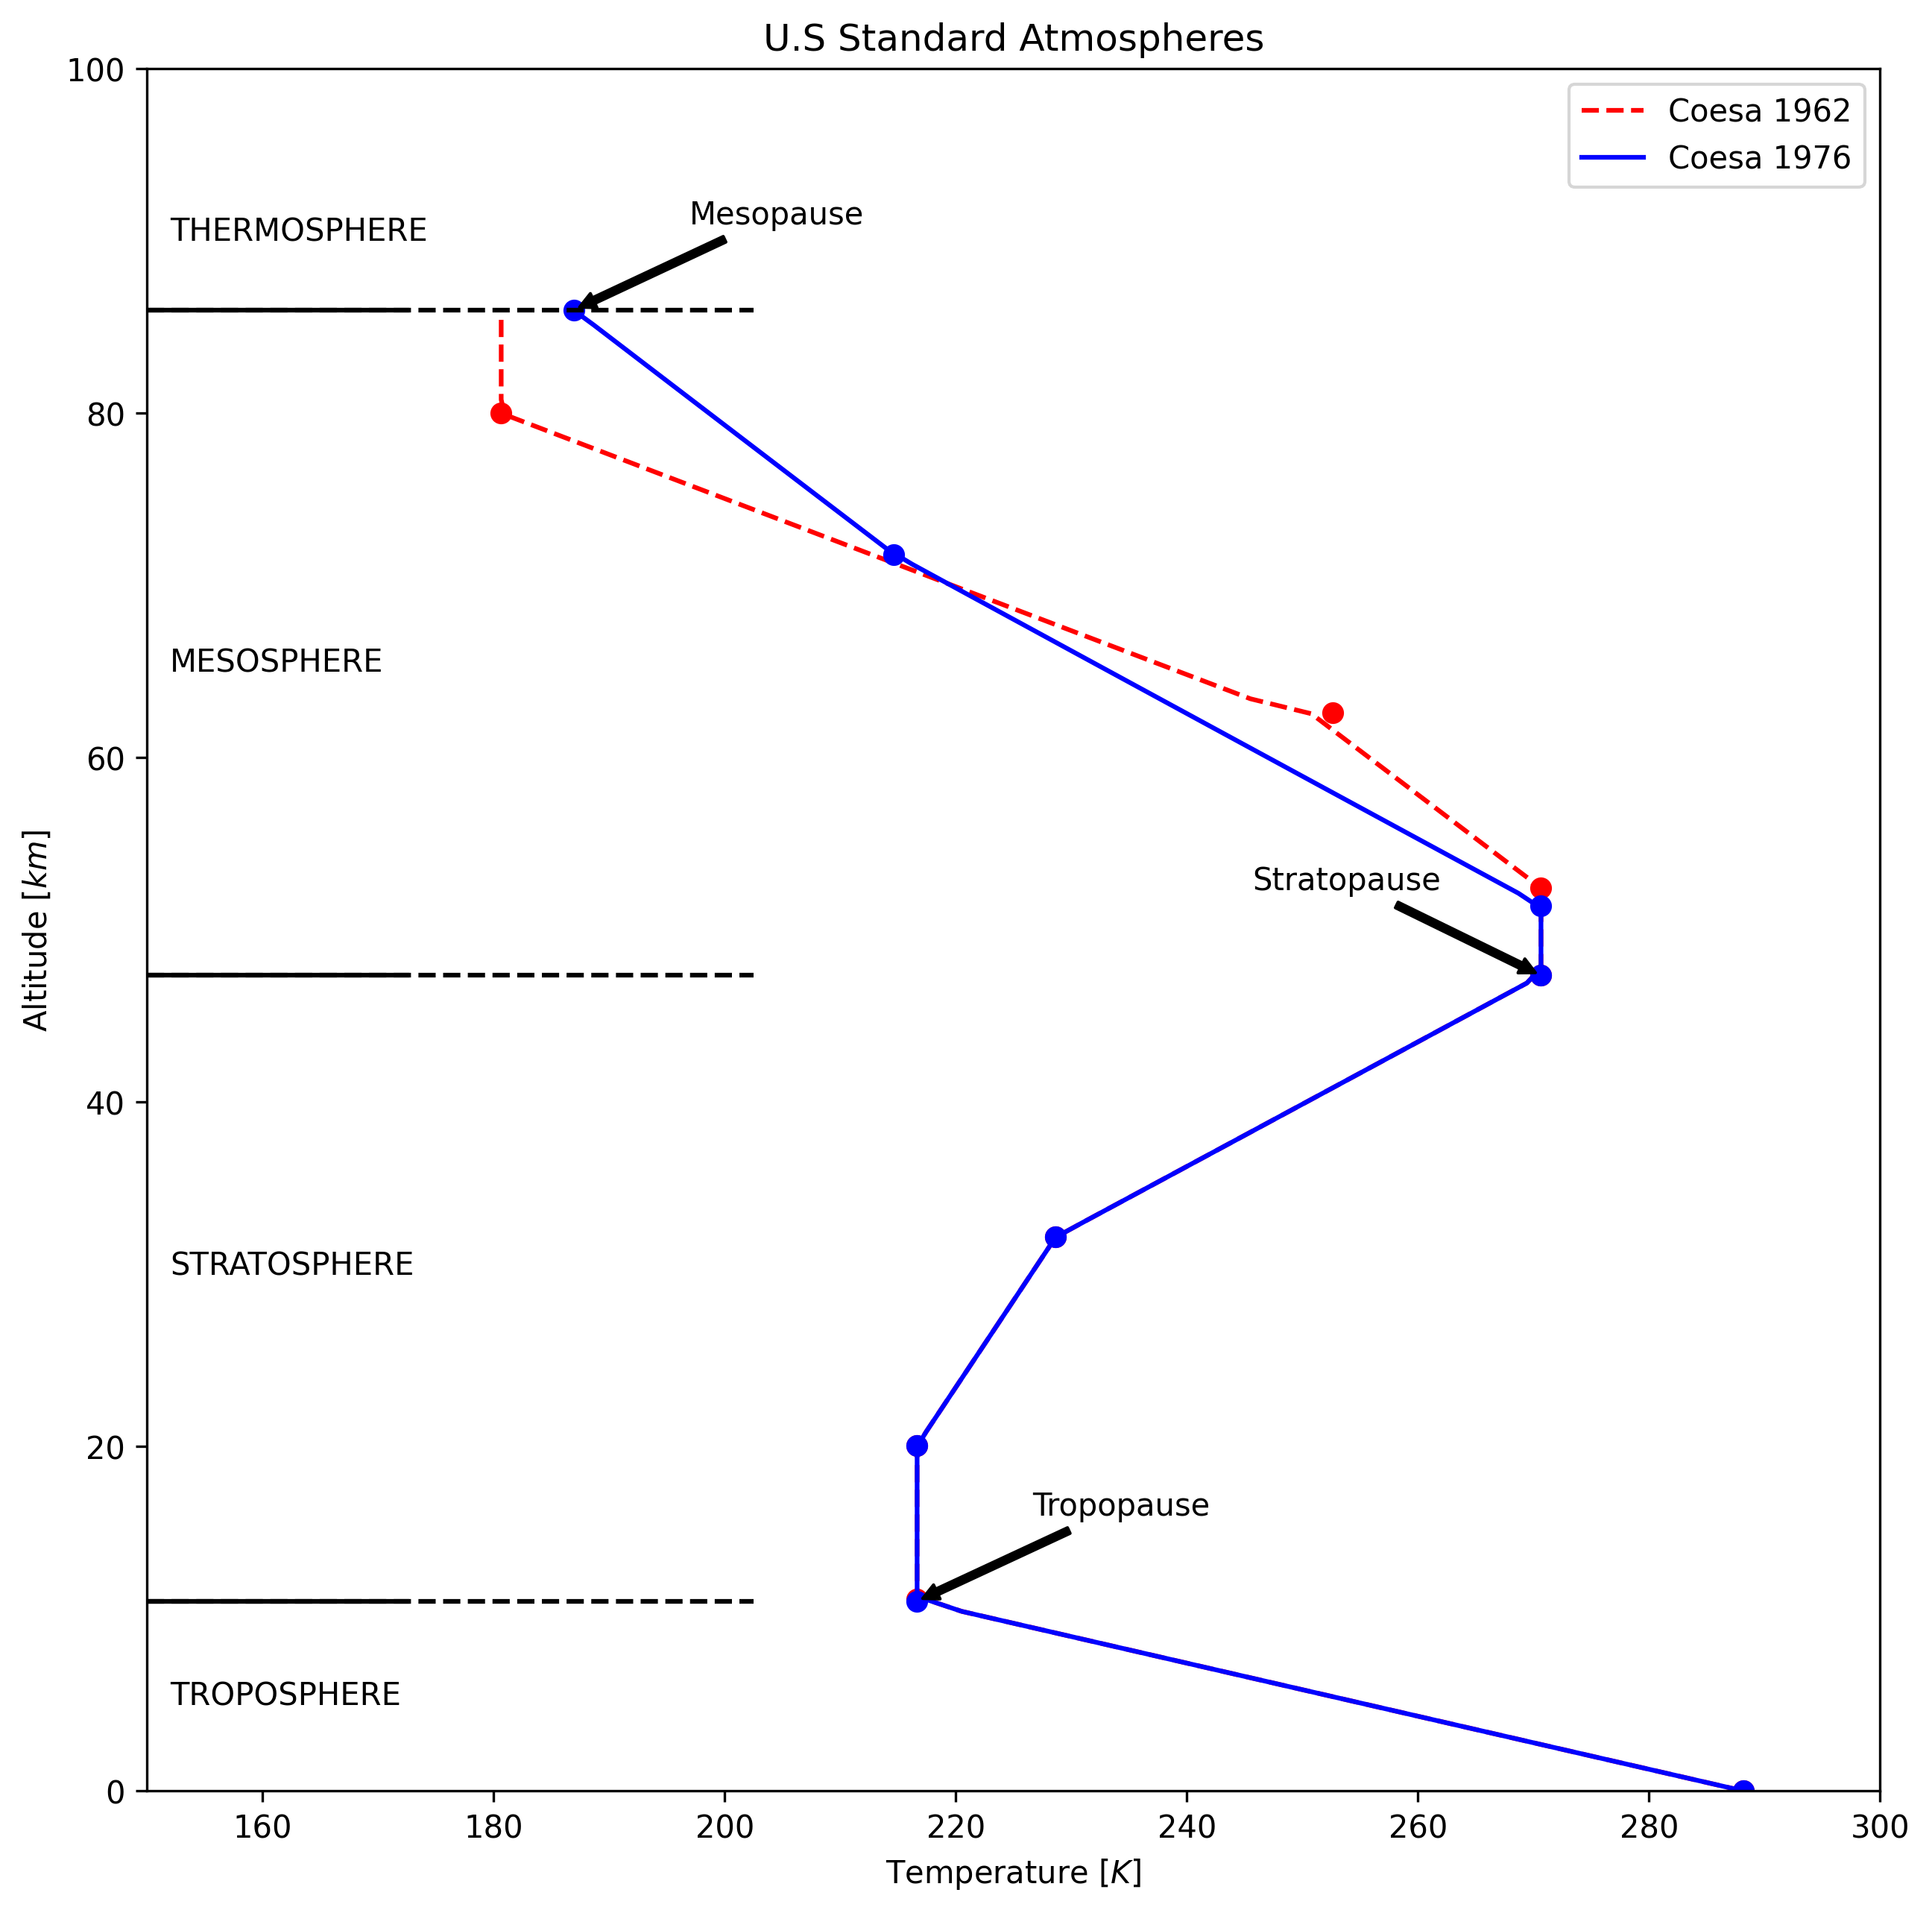

In [3]:
# We build the atmospheric instances
coesa62 = COESA62()
coesa76 = COESA76()

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("U.S Standard Atmospheres")

# Collect all atmospheric models and define their plotting properties
atm_models = {
    coesa62: ["--r", "r", "Coesa 1962"],
    coesa76: ["-b", "b", "Coesa 1976"],
}

# Solve atmospheric temperature for each of the models
for atm in atm_models:
    z_span = np.linspace(0, 86, 100) * u.km
    T_span = np.array([]) * u.K
    for z in z_span:
        # We discard density and pressure
        T = atm.temperature(z)
        T_span = np.append(T_span, T)

    # Temperature plot
    ax.plot(T_span, z_span, atm_models[atm][0], label=atm_models[atm][-1])
    ax.plot(atm.Tb_levels[:8], atm.zb_levels[:8], atm_models[atm][1] + "o")
    ax.set_xlim(150, 300)
    ax.set_ylim(0, 100)
    ax.set_xlabel("Temperature $[K]$")
    ax.set_ylabel("Altitude $[km]$")
    ax.legend()

# Add some information on the plot
ax.annotate(
    "Tropopause",
    xy=(coesa76.Tb_levels[1].value, coesa76.zb_levels[1].value),
    xytext=(coesa76.Tb_levels[1].value + 10, coesa76.zb_levels[1].value + 5),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)
ax.annotate(
    "Stratopause",
    xy=(coesa76.Tb_levels[4].value, coesa76.zb_levels[4].value),
    xytext=(coesa76.Tb_levels[4].value - 25, coesa76.zb_levels[4].value + 5),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)
ax.annotate(
    "Mesopause",
    xy=(coesa76.Tb_levels[7].value, coesa76.zb_levels[7].value),
    xytext=(coesa76.Tb_levels[7].value + 10, coesa76.zb_levels[7].value + 5),
    arrowprops=dict(arrowstyle="simple", facecolor="black"),
)

# Layers in the atmosphere
for h in [11.019, 47.350, 86]:
    ax.axhline(h, color="k", linestyle="--", xmin=0.0, xmax=0.35)
    ax.axhline(h, color="k", linestyle="-", xmin=0.0, xmax=0.15)

layer_names = {
    "TROPOSPHERE": 5,
    "STRATOSPHERE": 30,
    "MESOSPHERE": 65,
    "THERMOSPHERE": 90,
}
for name in layer_names:
    ax.annotate(
        name,
        xy=(152, layer_names[name]),
        xytext=(152, layer_names[name]),
    )
fig.savefig("plot01.png", dpi=300, format='png')

## Temperature, pressure and density distributions¶

One of the advantages of COESA76 is that it extends up to 1000 kilometers. The behaviour of previous magnitudes against geometrical altitude can be checked in the following figure. A logarithmic scale is applied for pressure and density to better see their decay for high altitude values:

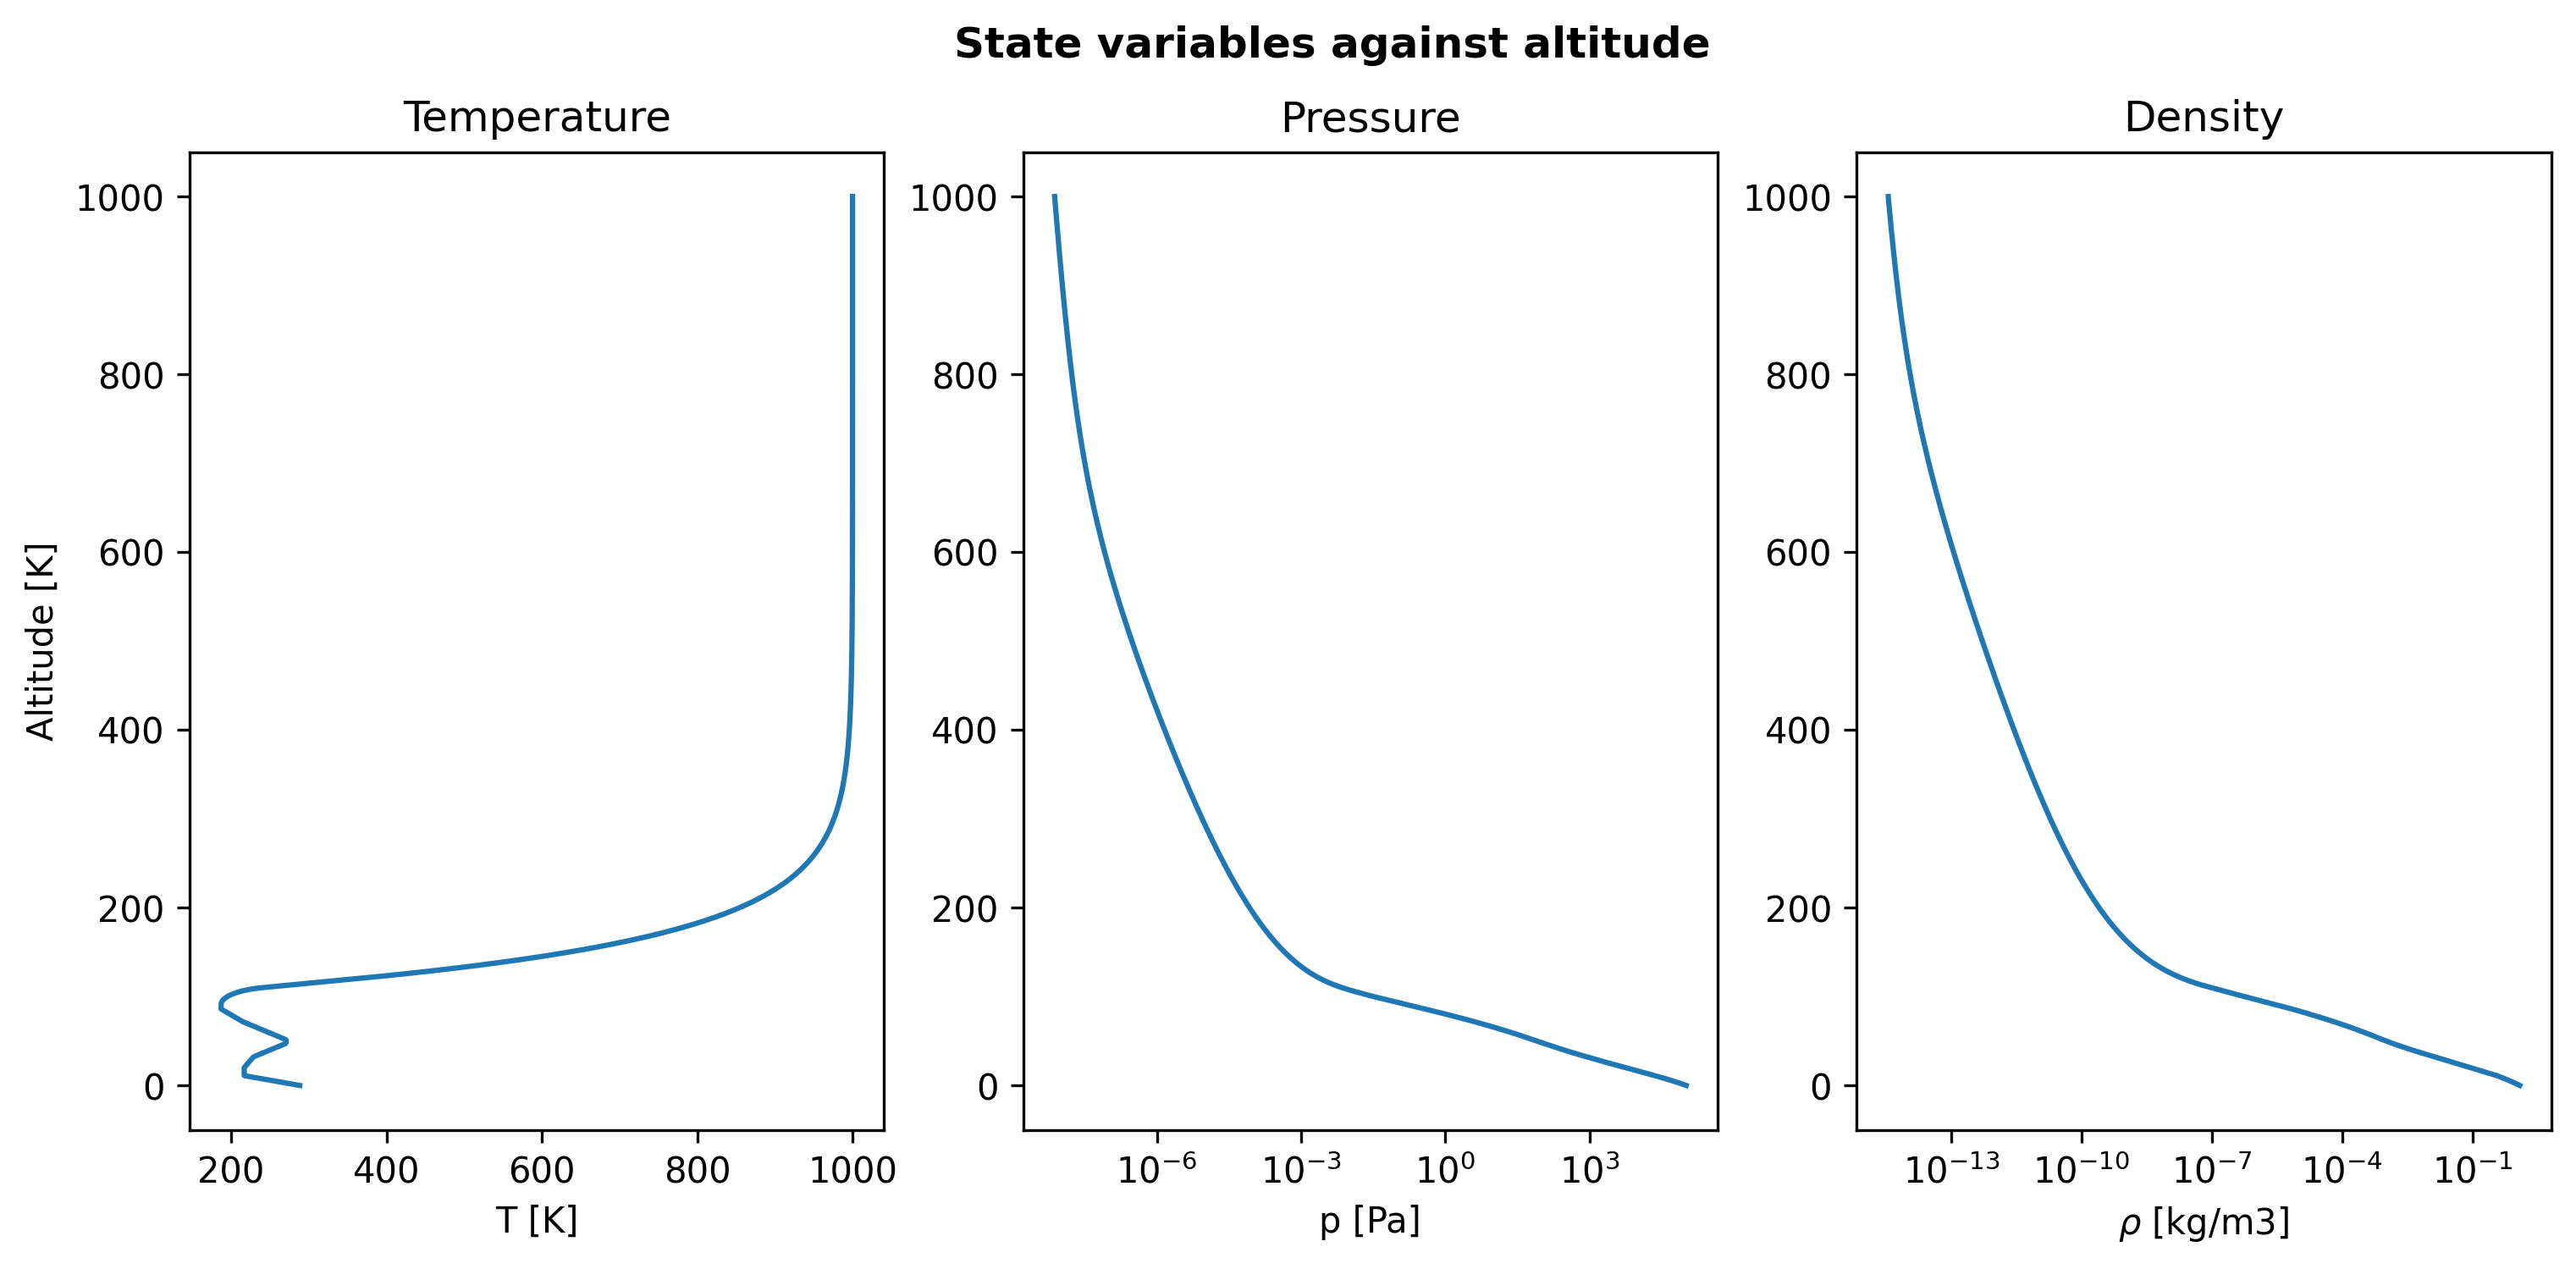

In [4]:
# We create the basis for the figure
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("State variables against altitude", fontweight="bold")

# Complete altitude range and initialization of state variables sets
alt_span = np.linspace(0, 1000, 1001) * u.km
T_span = np.array([]) * u.K
p_span = np.array([]) * u.Pa
rho_span = np.array([]) * u.kg / u.m**3

# We solve for each property at given altitude
for alt in alt_span:
    T, p, rho = coesa76.properties(alt)
    T_span = np.append(T_span, T)
    p_span = np.append(p_span, p.to(u.Pa))
    rho_span = np.append(rho_span, rho)

# Temperature plot
axs[0].set_title("Temperature")
axs[0].set_xlabel("T [K]")
axs[0].set_ylabel("Altitude [K]")
axs[0].plot(T_span, alt_span)

# Pressure plot
axs[1].set_title("Pressure")
axs[1].set_xlabel("p [Pa]")
axs[1].plot(p_span, alt_span)
axs[1].set_xscale("log")

# Density plot
axs[2].set_title("Density")
axs[2].set_xlabel(r"$\rho$ [kg/m3]")
axs[2].plot(rho_span, alt_span)
axs[2].set_xscale("log")

fig.savefig("plot02.png", dpi=300, format='png')

In [21]:
import math
def Atmosphere(alt):
    """ Compute temperature, density, and pressure in standard atmosphere.
    Correct to 86 km.  Only approximate thereafter.
    Input:
        alt	geometric altitude, km.
    Return: (sigma, delta, theta)
        sigma	density/sea-level standard density
        delta	pressure/sea-level standard pressure
        theta	temperature/sea-level std. temperature
    """
    REARTH = 6369.0		# radius of the Earth (km)
    GMR = 34.163195
    NTAB = 8			# length of tables
    htab = [ 0.0,  11.0, 20.0, 32.0, 47.0, 51.0, 71.0, 84.852 ]
    ttab = [ 288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65, 186.946 ]
    ptab = [ 1.0, 2.2336110E-1, 5.4032950E-2, 8.5666784E-3, 1.0945601E-3, 6.6063531E-4, 3.9046834E-5, 3.68501E-6 ]
    gtab = [ -6.5, 0.0, 1.0, 2.8, 0, -2.8, -2.0, 0.0 ]

    h = alt*REARTH/(alt+REARTH)	# geometric to geopotential altitude

    i=0; j=len(htab)
    while (j > i+1):
        k = int((i+j)/2)
        if h < htab[k]:
            j =(k)
        else:
            i = (k)
    tgrad = gtab[i]		# temp. gradient of local layer
    tbase = ttab[i]		# base  temp. of local layer
    deltah= h-htab[i]		# height above local base
    tlocal= tbase+tgrad*deltah	# local temperature
    theta = tlocal/ttab[0]	# temperature ratio

    if 0.0 == tgrad:
        delta = ptab[i]*math.exp(-GMR*deltah/tbase)
        sigma = 1
    else:
        delta = ptab[i]*math.pow(tbase/tlocal, GMR/tgrad)
        sigma = delta/theta
    return ( sigma, delta, theta )

In [22]:
print("Sigma, delta, theta at 0 km is:",  Atmosphere(0))
print("Sigma, delta, theta at 1 km is:", Atmosphere(1))
print("Sigma, delta, theta at 5 km is:", Atmosphere(5))
print("Sigma, delta, theta at 10 km is:", Atmosphere(10))

Sigma, delta, theta at 0 km is: (1.0, 1.0, 1.0)
Sigma, delta, theta at 1 km is: (0.9074773200465617, 0.8870099364510825, 0.977445845594875)
Sigma, delta, theta at 5 km is: (0.6011659785111773, 0.5334145710538502, 0.8872999972068988)
Sigma, delta, theta at 10 km is: (0.33755850295174866, 0.2615324521308304, 0.774776667877966)


In [23]:
round(Atmosphere(1)[0],4)

0.9075

In [25]:
print("Sigma, delta, theta at 0  km is:",  "(",round(Atmosphere(0)[0],4),",",round(Atmosphere(0)[1],4),",",round(Atmosphere(0)[2],4),")")

print("Sigma, delta, theta at 1  km is:",  "(",round(Atmosphere(1)[0],4),",",round(Atmosphere(1)[1],4),",",round(Atmosphere(1)[2],4),")")

print("Sigma, delta, theta at 5  km is:",  "(",round(Atmosphere(5)[0],4),",",round(Atmosphere(5)[1],4),",",round(Atmosphere(5)[2],4),")")

print("Sigma, delta, theta at 10 km is:",  "(",round(Atmosphere(10)[0],4),",",round(Atmosphere(10)[1],4),",",round(Atmosphere(10)[2],4),")")

print("Sigma, delta, theta at 15 km is:",  "(",round(Atmosphere(15)[0],4),",",round(Atmosphere(15)[1],4),",",round(Atmosphere(15)[2],4),")")

Sigma, delta, theta at 0  km is: ( 1.0 , 1.0 , 1.0 )
Sigma, delta, theta at 1  km is: ( 0.9075 , 0.887 , 0.9774 )
Sigma, delta, theta at 5  km is: ( 0.6012 , 0.5334 , 0.8873 )
Sigma, delta, theta at 10 km is: ( 0.3376 , 0.2615 , 0.7748 )
Sigma, delta, theta at 15 km is: ( 1 , 0.1195 , 0.7519 )


In [53]:
round(23.3,0)

23.0

In [34]:
int(23.3)

23